In [96]:
import numpy as np
import sklearn
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

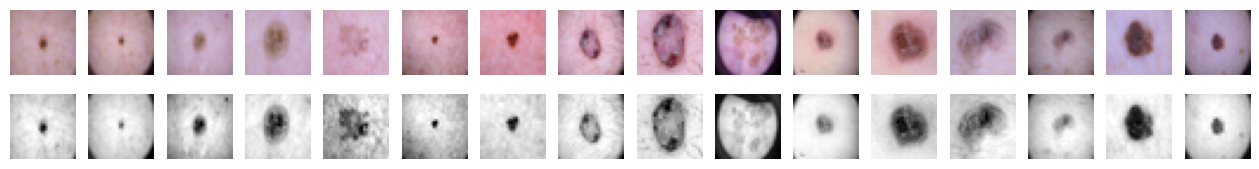

In [122]:
SIZE = 28
N = 16
OFFSET = 10
meta = pd.read_csv('metadata.csv', delimiter=',')
data = np.loadtxt(f'hmnist_{SIZE}_{SIZE}_L.csv', delimiter=',', skiprows=1, usecols=range(SIZE * SIZE))
data = np.apply_along_axis(lambda row: np.split(row, SIZE), arr=data, axis=1)
fig = plt.figure(figsize=(N, 2))
for i in range(1, N + 1):
    try:
        imgdata = Image.open("images1/" + meta.image_id[i + OFFSET] + ".jpg")
    except:
        imgdata = Image.open("images2/" + meta.image_id[i + OFFSET] + ".jpg")
    img = np.asarray(imgdata.resize((SIZE, SIZE)))
    fig.add_subplot(2, N, i)
    plt.axis("off")
    plt.imshow(img)
    fig.add_subplot(2, N, i + N)
    plt.axis("off")
    plt.imshow(data[i + OFFSET], cmap="gist_gray")
plt.show()